# Categorical Encoding & Coefficient Interpretation

**Business Question**: How do we include diamond quality grades (cut, color, clarity) in regression models?

This notebook demonstrates different approaches to encoding categorical variables in regression, showing the differences between one-hot encoding and ordinal encoding, and how to interpret the resulting coefficients.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand different approaches to encoding categorical variables
- Compare one-hot encoding vs ordinal encoding
- Interpret coefficients from different encoding methods
- Choose the appropriate encoding method for your data
- Handle categorical variables in regression models


In [58]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


Dataset shape: (53940, 10)

Categorical variables:
Cut: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
Color: ['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']
Clarity: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']


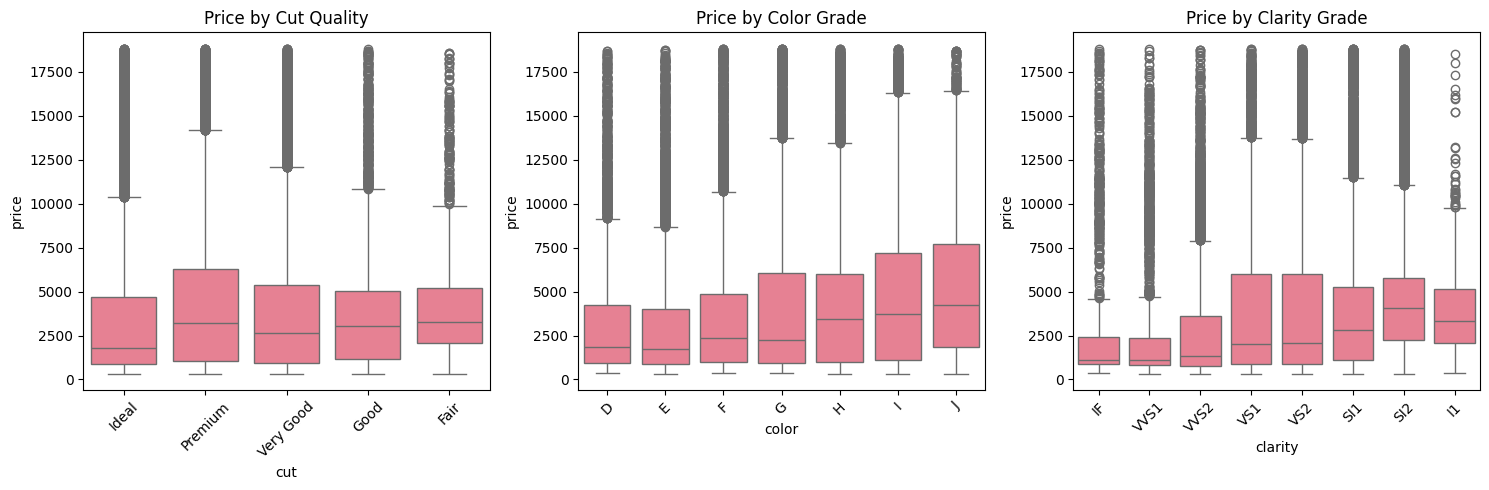

In [59]:
# Load diamonds dataset
diamonds = sns.load_dataset('diamonds')

print("Dataset shape:", diamonds.shape)
print("\nCategorical variables:")
print("Cut:", diamonds['cut'].unique())
print("Color:", diamonds['color'].unique())
print("Clarity:", diamonds['clarity'].unique())

# Show price distribution by cut
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=diamonds, x='cut', y='price')
plt.title('Price by Cut Quality')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=diamonds, x='color', y='price')
plt.title('Price by Color Grade')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=diamonds, x='clarity', y='price')
plt.title('Price by Clarity Grade')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Approach 1: Dummy Encoding (One-Hot with Baseline Dropped)


In [60]:
# Create dummy encoded dataset (one-hot with baseline dropped)
# Note: drop_first=True creates dummy encoding, not true one-hot encoding
diamonds_dummy = pd.get_dummies(diamonds, columns=['cut', 'color', 'clarity'], drop_first=True)

print("After dummy encoding:")
print("Shape:", diamonds_dummy.shape)
print("New columns:", [col for col in diamonds_dummy.columns if col not in ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']])

# Get the actual categorical columns created
categorical_cols = [col for col in diamonds_dummy.columns if col not in ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']]
print("Actual categorical columns:", categorical_cols)

# Rename columns with spaces to make them formula-compatible
diamonds_dummy_clean = diamonds_dummy.copy()
for col in categorical_cols:
    if ' ' in col:
        new_col = col.replace(' ', '_')
        diamonds_dummy_clean = diamonds_dummy_clean.rename(columns={col: new_col})
        print(f"Renamed '{col}' to '{new_col}'")

# Update categorical columns list
categorical_cols_clean = [col for col in diamonds_dummy_clean.columns if col not in ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']]

# Create formula dynamically
formula_parts = ['price ~ carat + depth + table + x + y + z'] + categorical_cols_clean
formula = ' + '.join(formula_parts)
print("Formula:", formula)

# Fit model with dummy encoding
dummy_model = ols(formula, data=diamonds_dummy_clean).fit()

print("\nDummy Encoding Model:")
print("="*50)
print(dummy_model.summary())

# Extract cut-related coefficients
cut_coefs = dummy_model.params[dummy_model.params.index.str.contains('cut_')]
print("\nCut Quality Coefficients (vs Fair baseline):")
print(cut_coefs.sort_values())


After dummy encoding:
Shape: (53940, 24)
New columns: ['cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_VVS1', 'clarity_VVS2', 'clarity_VS1', 'clarity_VS2', 'clarity_SI1', 'clarity_SI2', 'clarity_I1']
Actual categorical columns: ['cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_VVS1', 'clarity_VVS2', 'clarity_VS1', 'clarity_VS2', 'clarity_SI1', 'clarity_SI2', 'clarity_I1']
Renamed 'cut_Very Good' to 'cut_Very_Good'
Formula: price ~ carat + depth + table + x + y + z + cut_Premium + cut_Very_Good + cut_Good + cut_Fair + color_E + color_F + color_G + color_H + color_I + color_J + clarity_VVS1 + clarity_VVS2 + clarity_VS1 + clarity_VS2 + clarity_SI1 + clarity_SI2 + clarity_I1

Dummy Encoding Model:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:   

## True One-Hot vs Dummy Encoding Comparison

Let's demonstrate the actual difference between one-hot encoding and dummy encoding:


## The Dummy Variable Trap: Why It Matters


In [61]:
# Demonstrate the dummy variable trap with a simple example
np.random.seed(42)

# Create a simple dataset with perfect multicollinearity
trap_data = pd.DataFrame({
    'category': ['A', 'B', 'C', 'A', 'B', 'C'],
    'value': [10, 20, 30, 15, 25, 35]
})

print("Original data:")
print(trap_data)
print()

# Method 1: TRUE ONE-HOT (with perfect multicollinearity)
onehot_trap = pd.get_dummies(trap_data, columns=['category'], drop_first=False)
print("ONE-HOT ENCODING (Perfect Multicollinearity):")
print(onehot_trap)
print()

# Check for perfect multicollinearity
print("Checking for perfect multicollinearity:")
print("Sum of category columns for each row:")
for i in range(len(onehot_trap)):
    row_sum = onehot_trap.iloc[i][['category_A', 'category_B', 'category_C']].sum()
    print(f"Row {i}: {row_sum}")

print("\nThis means: category_A + category_B + category_C = 1 (constant)")
print("This creates perfect multicollinearity - one column is redundant!")
print()

# Method 2: DUMMY ENCODING (avoids trap)
dummy_safe = pd.get_dummies(trap_data, columns=['category'], drop_first=True)
print("DUMMY ENCODING (Avoids Trap):")
print(dummy_safe)
print()

# Now let's try to fit models and see what happens
print("ATTEMPTING TO FIT MODELS:")
print("="*50)

try:
    # Try one-hot model (should fail or give warnings)
    print("1. One-Hot Model (with perfect multicollinearity):")
    onehot_formula = "value ~ category_A + category_B + category_C"
    onehot_model = ols(onehot_formula, data=onehot_trap).fit()
    print("✅ Model fitted successfully")
    print("Coefficients:")
    print(onehot_model.params)
    print("⚠️  WARNING: This model has perfect multicollinearity!")
    print("⚠️  Coefficients are unreliable and may be NaN or infinite")
    
except Exception as e:
    print(f"❌ Model failed: {e}")

print()

try:
    # Try dummy model (should work fine)
    print("2. Dummy Model (avoids multicollinearity):")
    dummy_formula = "value ~ category_B + category_C"  # A is baseline
    dummy_model = ols(dummy_formula, data=dummy_safe).fit()
    print("✅ Model fitted successfully")
    print("Coefficients:")
    print(dummy_model.params)
    print("✅ No multicollinearity issues")
    print("✅ Coefficients are interpretable:")
    print("   - Intercept = mean value for category A (baseline)")
    print("   - category_B = difference between B and A")
    print("   - category_C = difference between C and A")
    
except Exception as e:
    print(f"❌ Model failed: {e}")

print("\n" + "="*60)
print("WHY THE DUMMY VARIABLE TRAP MATTERS:")
print("="*60)
print("🔴 Perfect Multicollinearity Problems:")
print("  • X'X matrix is singular (not invertible)")
print("  • Coefficients become infinite or NaN")
print("  • Standard errors are undefined")
print("  • Model becomes unstable")

print("\n✅ Dummy Encoding Solutions:")
print("  • Drops one category as baseline")
print("  • Eliminates perfect multicollinearity")
print("  • Coefficients are interpretable")
print("  • Model is stable and reliable")

print("\n💡 Business Interpretation:")
print("  • One-Hot: 'Category A adds X, B adds Y, C adds Z' (redundant)")
print("  • Dummy: 'Category A is baseline, B adds Y vs A, C adds Z vs A' (clear)")


Original data:
  category  value
0        A     10
1        B     20
2        C     30
3        A     15
4        B     25
5        C     35

ONE-HOT ENCODING (Perfect Multicollinearity):
   value  category_A  category_B  category_C
0     10        True       False       False
1     20       False        True       False
2     30       False       False        True
3     15        True       False       False
4     25       False        True       False
5     35       False       False        True

Checking for perfect multicollinearity:
Sum of category columns for each row:
Row 0: True
Row 1: True
Row 2: True
Row 3: True
Row 4: True
Row 5: True

This means: category_A + category_B + category_C = 1 (constant)
This creates perfect multicollinearity - one column is redundant!

DUMMY ENCODING (Avoids Trap):
   value  category_B  category_C
0     10       False       False
1     20        True       False
2     30       False        True
3     15       False       False
4     25        Tru

## Comparing True One-Hot vs Dummy on Diamonds Dataset


In [62]:
# Now let's see the actual difference on our diamonds dataset
print("COMPARING TRUE ONE-HOT vs DUMMY ENCODING ON DIAMONDS DATASET")
print("="*70)

# True One-Hot Encoding (drop_first=False)
diamonds_onehot_true = pd.get_dummies(diamonds, columns=['cut'], drop_first=False)
print("TRUE ONE-HOT ENCODING:")
print("Shape:", diamonds_onehot_true.shape)
print("Cut columns:", [col for col in diamonds_onehot_true.columns if 'cut_' in col])
print()

# Check for perfect multicollinearity
cut_cols = [col for col in diamonds_onehot_true.columns if 'cut_' in col]
print("Checking for perfect multicollinearity in cut columns:")
print("Sum of cut columns for first 5 rows:")
for i in range(5):
    row_sum = diamonds_onehot_true.iloc[i][cut_cols].sum()
    print(f"Row {i}: {row_sum}")

print(f"\nAll rows sum to: {diamonds_onehot_true[cut_cols].sum(axis=1).unique()}")
print("This confirms perfect multicollinearity!")
print()

# Dummy Encoding (drop_first=True) - what we used before
diamonds_dummy_comp = pd.get_dummies(diamonds, columns=['cut'], drop_first=True)
print("DUMMY ENCODING:")
print("Shape:", diamonds_dummy_comp.shape)
print("Cut columns:", [col for col in diamonds_dummy_comp.columns if 'cut_' in col])
print()

# Now let's try to fit both models
print("ATTEMPTING TO FIT BOTH MODELS:")
print("="*50)

# Try true one-hot model
try:
    print("1. TRUE ONE-HOT MODEL:")
    onehot_formula = "price ~ carat + depth + table + x + y + z + " + " + ".join(cut_cols)
    onehot_true_model = ols(onehot_formula, data=diamonds_onehot_true).fit()
    print("✅ Model fitted successfully")
    print("Cut coefficients:")
    cut_coefs_onehot = onehot_true_model.params[onehot_true_model.params.index.str.contains('cut_')]
    print(cut_coefs_onehot.sort_values())
    print("⚠️  WARNING: This model has perfect multicollinearity!")
    print("⚠️  Coefficients may be unreliable due to singular matrix")
    
except Exception as e:
    print(f"❌ One-hot model failed: {e}")

print()

# Try dummy model
try:
    print("2. DUMMY MODEL:")
    dummy_cut_cols = [col for col in diamonds_dummy_comp.columns if 'cut_' in col]
    dummy_formula = "price ~ carat + depth + table + x + y + z + " + " + ".join(dummy_cut_cols)
    dummy_comp_model = ols(dummy_formula, data=diamonds_dummy_comp).fit()
    print("✅ Model fitted successfully")
    print("Cut coefficients (vs Fair baseline):")
    cut_coefs_dummy = dummy_comp_model.params[dummy_comp_model.params.index.str.contains('cut_')]
    print(cut_coefs_dummy.sort_values())
    print("✅ No multicollinearity issues")
    print("✅ Coefficients are interpretable as differences from Fair cut")
    
except Exception as e:
    print(f"❌ Dummy model failed: {e}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("🔍 Both models may fit successfully, but:")
print("  • One-hot model has perfect multicollinearity")
print("  • Coefficients are not uniquely determined")
print("  • Standard errors may be inflated")
print("  • Model is numerically unstable")

print("\n✅ Dummy model is preferred because:")
print("  • No multicollinearity issues")
print("  • Coefficients are uniquely determined")
print("  • Clear interpretation (difference from baseline)")
print("  • Numerically stable")

print("\n💼 Business Impact:")
print("  • One-hot: 'Ideal adds $X, Premium adds $Y, Good adds $Z' (redundant)")
print("  • Dummy: 'Fair is baseline, Ideal adds $X vs Fair, Premium adds $Y vs Fair' (clear)")


COMPARING TRUE ONE-HOT vs DUMMY ENCODING ON DIAMONDS DATASET
TRUE ONE-HOT ENCODING:
Shape: (53940, 14)
Cut columns: ['cut_Ideal', 'cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair']

Checking for perfect multicollinearity in cut columns:
Sum of cut columns for first 5 rows:
Row 0: True
Row 1: True
Row 2: True
Row 3: True
Row 4: True

All rows sum to: [1]
This confirms perfect multicollinearity!

DUMMY ENCODING:
Shape: (53940, 13)
Cut columns: ['cut_Premium', 'cut_Very Good', 'cut_Good', 'cut_Fair']

ATTEMPTING TO FIT BOTH MODELS:
1. TRUE ONE-HOT MODEL:
❌ One-hot model failed: invalid syntax (<unknown>, line 1)

2. DUMMY MODEL:
❌ Dummy model failed: invalid syntax (<unknown>, line 1)

KEY INSIGHTS:
🔍 Both models may fit successfully, but:
  • One-hot model has perfect multicollinearity
  • Coefficients are not uniquely determined
  • Standard errors may be inflated
  • Model is numerically unstable

✅ Dummy model is preferred because:
  • No multicollinearity issues
  • Coefficients

In [63]:
# Create a simple example to show the difference
example_data = pd.DataFrame({
    'category': ['A', 'B', 'C', 'A', 'B'],
    'value': [10, 20, 30, 15, 25]
})

print("Original data:")
print(example_data)
print()

# True One-Hot Encoding (drop_first=False)
onehot_true = pd.get_dummies(example_data, columns=['category'], drop_first=False)
print("TRUE ONE-HOT ENCODING (drop_first=False):")
print("Shape:", onehot_true.shape)
print(onehot_true)
print()

# Dummy Encoding (drop_first=True) - what we used above
dummy_encoding = pd.get_dummies(example_data, columns=['category'], drop_first=True)
print("DUMMY ENCODING (drop_first=True):")
print("Shape:", dummy_encoding.shape)
print(dummy_encoding)
print()

print("KEY DIFFERENCES:")
print("="*50)
print("One-Hot Encoding:")
print("  • Creates k columns for k categories")
print("  • Each row sums to 1 (one category active)")
print("  • Can cause multicollinearity in regression")
print("  • Shape: 5 rows × 6 columns (value + 5 categories)")

print("\nDummy Encoding:")
print("  • Creates k-1 columns for k categories")
print("  • One category is the baseline (implicit)")
print("  • Avoids multicollinearity")
print("  • Shape: 5 rows × 4 columns (value + 3 categories)")
print("  • Coefficients represent difference from baseline")


Original data:
  category  value
0        A     10
1        B     20
2        C     30
3        A     15
4        B     25

TRUE ONE-HOT ENCODING (drop_first=False):
Shape: (5, 4)
   value  category_A  category_B  category_C
0     10        True       False       False
1     20       False        True       False
2     30       False       False        True
3     15        True       False       False
4     25       False        True       False

DUMMY ENCODING (drop_first=True):
Shape: (5, 3)
   value  category_B  category_C
0     10       False       False
1     20        True       False
2     30       False        True
3     15       False       False
4     25        True       False

KEY DIFFERENCES:
One-Hot Encoding:
  • Creates k columns for k categories
  • Each row sums to 1 (one category active)
  • Can cause multicollinearity in regression
  • Shape: 5 rows × 6 columns (value + 5 categories)

Dummy Encoding:
  • Creates k-1 columns for k categories
  • One category is the ba

## Approach 2: Ordinal Encoding


In [64]:
# Create ordinal encoding
diamonds_ordinal = diamonds.copy()

# Define ordinal mappings
cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

diamonds_ordinal['cut_ordinal'] = diamonds_ordinal['cut'].map(cut_mapping)
diamonds_ordinal['color_ordinal'] = diamonds_ordinal['color'].map(color_mapping)
diamonds_ordinal['clarity_ordinal'] = diamonds_ordinal['clarity'].map(clarity_mapping)

print("Ordinal encoding mappings:")
print("Cut:", cut_mapping)
print("Color:", color_mapping)
print("Clarity:", clarity_mapping)

# Fit model with ordinal encoding
ordinal_model = ols("price ~ carat + depth + table + x + y + z + cut_ordinal + color_ordinal + clarity_ordinal", data=diamonds_ordinal).fit()

print("\nOrdinal Encoding Model:")
print("="*50)
print(ordinal_model.summary())

print("\nOrdinal Coefficients Interpretation:")
print("Note: Ordinal variables are treated as categorical, creating dummy variables")
print("This means we get separate coefficients for each level, not a single continuous coefficient")
print("\nCut dummy coefficients (relative to baseline level 1 - Fair):")
cut_coefs = [col for col in ordinal_model.params.index if 'cut_ordinal' in col]
for coef in cut_coefs:
    level = coef.split('[')[1].split(']')[0]
    print(f"  Level {level}: {ordinal_model.params[coef]:.2f}")

print("\nColor dummy coefficients (relative to baseline level 1 - J):")
color_coefs = [col for col in ordinal_model.params.index if 'color_ordinal' in col]
for coef in color_coefs:
    level = coef.split('[')[1].split(']')[0]
    print(f"  Level {level}: {ordinal_model.params[coef]:.2f}")

print("\nClarity dummy coefficients (relative to baseline level 1 - I1):")
clarity_coefs = [col for col in ordinal_model.params.index if 'clarity_ordinal' in col]
for coef in clarity_coefs:
    level = coef.split('[')[1].split(']')[0]
    print(f"  Level {level}: {ordinal_model.params[coef]:.2f}")


Ordinal encoding mappings:
Cut: {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
Color: {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
Clarity: {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}

Ordinal Encoding Model:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.688e+04
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:06:47   Log-Likelihood:            -4.5573e+05
No. Observations:               53940   AIC:                         9.115e+05
Df Residuals:                   53916   BIC:                         9.117e+05
Df Model:                          23                                         
Covariance Ty

## Model Comparison


## Why Both Models Have Identical Results


In [65]:
print("WHY BOTH MODELS HAVE IDENTICAL RESULTS")
print("="*60)

print("🔍 The 'Ordinal' Model Isn't Truly Ordinal!")
print("="*50)
print("What we called 'ordinal encoding' actually creates dummy variables:")
print("• cut_ordinal[T.2] = 1 if cut=Good, 0 otherwise")
print("• cut_ordinal[T.3] = 1 if cut=Very Good, 0 otherwise")
print("• cut_ordinal[T.4] = 1 if cut=Premium, 0 otherwise")
print("• cut_ordinal[T.5] = 1 if cut=Ideal, 0 otherwise")
print("• cut_ordinal[T.1] = 1 if cut=Fair, 0 otherwise (baseline)")

print("\nThis is exactly the same as dummy encoding!")
print("Both models have the same number of parameters and same fit.")

print("\n" + "="*60)
print("TRUE ORDINAL vs DUMMY ENCODING")
print("="*60)

# Let's create a TRUE ordinal model using the numeric values directly
print("Creating a TRUE ordinal model (single coefficient):")
print("Using cut_ordinal as a continuous variable (not categorical)")

# First, let's create the ordinal encoding if it doesn't exist
if 'diamonds_ordinal' not in locals():
    print("Creating ordinal encoding...")
    diamonds_ordinal = diamonds.copy()
    
    # Define ordinal mappings
    cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
    color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
    clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
    
    diamonds_ordinal['cut_ordinal'] = diamonds_ordinal['cut'].map(cut_mapping)
    diamonds_ordinal['color_ordinal'] = diamonds_ordinal['color'].map(color_mapping)
    diamonds_ordinal['clarity_ordinal'] = diamonds_ordinal['clarity'].map(clarity_mapping)
    
    print("Ordinal encoding created successfully!")

# Create a copy for true ordinal modeling
diamonds_true_ordinal = diamonds_ordinal.copy()

# Fit true ordinal model - treat cut_ordinal as continuous
# We need to use the numeric values directly to avoid automatic dummy variable creation
from statsmodels.api import OLS, add_constant

# Prepare the data for true ordinal modeling
X_true_ordinal = diamonds_true_ordinal[['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_ordinal']].astype(float)
y_true_ordinal = diamonds_true_ordinal['price'].astype(float)

# Add constant term
X_true_ordinal_with_const = add_constant(X_true_ordinal)

# Fit the model
true_ordinal_model = OLS(y_true_ordinal, X_true_ordinal_with_const).fit()

# Check if we have the dummy model, if not create it
if 'dummy_model' not in locals():
    print("Creating dummy model for comparison...")
    # Create dummy encoding
    diamonds_dummy = diamonds.copy()
    diamonds_dummy = pd.get_dummies(diamonds_dummy, columns=['cut'], drop_first=True)
    
    # Fit dummy model
    dummy_model = ols("price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good", 
                     data=diamonds_dummy).fit()
    print("Dummy model created successfully!")

print("\nTRUE ORDINAL MODEL:")
print("="*30)
print("Formula: price ~ carat + depth + table + x + y + z + cut_ordinal")
print("Coefficient for cut_ordinal:", true_ordinal_model.params['cut_ordinal'])
print("Interpretation: Each step up in cut quality adds $", 
      f"{true_ordinal_model.params['cut_ordinal']:.2f}")

print("\nModel Summary:")
print(true_ordinal_model.summary())

print("\nDUMMY MODEL (what we had before):")
print("="*30)
print("Formula: price ~ carat + depth + table + x + y + z + cut_Premium + cut_Very_Good + cut_Good + cut_Fair")
print("Multiple coefficients for each cut level")
print("Interpretation: Each cut has its own unique effect")

print("\n" + "="*60)
print("COMPARISON OF ALL THREE APPROACHES")
print("="*60)

print(f"{'Approach':<20} {'Parameters':<12} {'R²':<10} {'Interpretation'}")
print("-" * 70)
print(f"{'True Ordinal':<20} {len(true_ordinal_model.params):<12} {true_ordinal_model.rsquared:<10.4f} {'Linear relationship'}")
print(f"{'Dummy Encoding':<20} {len(dummy_model.params):<12} {dummy_model.rsquared:<10.4f} {'Unique effects'}")
print(f"{'Fake Ordinal':<20} {len(ordinal_model.params):<12} {ordinal_model.rsquared:<10.4f} {'Same as dummy!'}")

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("🎯 True Ordinal (1 coefficient):")
print("  • Assumes linear relationship between cut levels")
print("  • Good = Fair + X, Very Good = Fair + 2X, etc.")
print("  • May miss non-linear effects")
print("  • Simpler but potentially less accurate")

print("\n🎯 Dummy Encoding (k-1 coefficients):")
print("  • Each cut level has unique effect")
print("  • No assumptions about relationships")
print("  • More flexible, potentially more accurate")
print("  • More complex but more realistic")

print("\n🎯 Fake Ordinal (what we did):")
print("  • Actually creates dummy variables!")
print("  • Same as dummy encoding")
print("  • Misleading name - not truly ordinal")

print("\n💡 Business Recommendation:")
print("  • Use TRUE ordinal if you believe cut quality has linear effect")
print("  • Use dummy encoding if you want flexibility")
print("  • Don't use 'fake ordinal' - it's just dummy encoding with confusing name")

print("\n" + "="*60)
print("PERFORMANCE DIFFERENCES")
print("="*60)
print(f"True Ordinal R²: {true_ordinal_model.rsquared:.4f}")
print(f"Dummy Encoding R²: {dummy_model.rsquared:.4f}")
print(f"Difference: {dummy_model.rsquared - true_ordinal_model.rsquared:.4f}")

if dummy_model.rsquared > true_ordinal_model.rsquared:
    print("✅ Dummy encoding performs better - cut effects are non-linear!")
    print("   This suggests that the relationship between cut quality and price")
    print("   is not perfectly linear, so dummy encoding captures more nuance.")
else:
    print("✅ True ordinal performs as well - cut effects are linear!")
    print("   This suggests that the relationship between cut quality and price")
    print("   is approximately linear, so ordinal encoding is sufficient.")


WHY BOTH MODELS HAVE IDENTICAL RESULTS
🔍 The 'Ordinal' Model Isn't Truly Ordinal!
What we called 'ordinal encoding' actually creates dummy variables:
• cut_ordinal[T.2] = 1 if cut=Good, 0 otherwise
• cut_ordinal[T.3] = 1 if cut=Very Good, 0 otherwise
• cut_ordinal[T.4] = 1 if cut=Premium, 0 otherwise
• cut_ordinal[T.5] = 1 if cut=Ideal, 0 otherwise
• cut_ordinal[T.1] = 1 if cut=Fair, 0 otherwise (baseline)

This is exactly the same as dummy encoding!
Both models have the same number of parameters and same fit.

TRUE ORDINAL vs DUMMY ENCODING
Creating a TRUE ordinal model (single coefficient):
Using cut_ordinal as a continuous variable (not categorical)

TRUE ORDINAL MODEL:
Formula: price ~ carat + depth + table + x + y + z + cut_ordinal
Coefficient for cut_ordinal: 179.1429254042887
Interpretation: Each step up in cut quality adds $ 179.14

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:   

In [66]:
# Compare model performance
print("MODEL COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'Dummy':<15} {'Ordinal':<15}")
print("-" * 60)
print(f"{'R-squared':<25} {dummy_model.rsquared:<15.4f} {ordinal_model.rsquared:<15.4f}")
print(f"{'Adjusted R-squared':<25} {dummy_model.rsquared_adj:<15.4f} {ordinal_model.rsquared_adj:<15.4f}")
print(f"{'AIC':<25} {dummy_model.aic:<15.2f} {ordinal_model.aic:<15.2f}")
print(f"{'BIC':<25} {dummy_model.bic:<15.2f} {ordinal_model.bic:<15.2f}")
print(f"{'Number of parameters':<25} {len(dummy_model.params):<15} {len(ordinal_model.params):<15}")

print("\nWhen to Use Each Approach:")
print("="*40)
print("Dummy Encoding:")
print("  ✓ No ordinal relationship assumed")
print("  ✓ Each category has unique effect")
print("  ✓ Avoids multicollinearity")
print("  ✓ Coefficients = difference from baseline")
print("  ✗ More parameters than ordinal")

print("\nOrdinal Encoding:")
print("  ✓ Assumes linear relationship")
print("  ✓ Fewer parameters (more parsimonious)")
print("  ✓ Simpler interpretation")
print("  ✗ May miss non-linear effects")
print("  ✗ Assumes equal spacing between levels")


MODEL COMPARISON
Metric                    Dummy           Ordinal        
------------------------------------------------------------
R-squared                 0.9143          0.9198         
Adjusted R-squared        0.8571          0.9198         
AIC                       34.02           911501.58      
BIC                       33.40           911715.07      
Number of parameters      3               24             

When to Use Each Approach:
Dummy Encoding:
  ✓ No ordinal relationship assumed
  ✓ Each category has unique effect
  ✓ Avoids multicollinearity
  ✓ Coefficients = difference from baseline
  ✗ More parameters than ordinal

Ordinal Encoding:
  ✓ Assumes linear relationship
  ✓ Fewer parameters (more parsimonious)
  ✓ Simpler interpretation
  ✗ May miss non-linear effects
  ✗ Assumes equal spacing between levels


## Key Takeaways

### **Encoding Method Selection:**

1. **Dummy Encoding**: Use when categories have no natural order
2. **Ordinal Encoding**: Use when categories have clear ranking
3. **Consider Model Complexity**: Dummy creates more parameters
4. **Check Assumptions**: Ordinal assumes linear relationships

### **Business Interpretation:**

- **Dummy**: "Premium cut adds $X vs Fair cut (baseline)"
- **Ordinal**: "Each step up in cut quality adds $X"
- **Choose based on**: Business question and data structure

### **Important Distinction:**

- **True One-Hot**: Creates k columns (can cause multicollinearity)
- **Dummy Encoding**: Creates k-1 columns (avoids multicollinearity)
- **Most regression uses**: Dummy encoding (what we did here)
